In [69]:
import os
import pandas
import numpy as np

path='/tsukimi/datasets/Chiba/baseline/datalist/train.csv'

# read csv
df = pandas.read_csv(path, header=None)
df.columns = ['path', 'label']
df['label']=df['label'].map(lambda x: x.split('&'))
label_map={}
# count labels
for label in df['label']:
    for l in label:
        if l in label_map:
            label_map[l]+=1
        else:
            label_map[l]=1

In [70]:
label_map

{'interaction_with_partner': 3798,
 'others': 10740,
 'restrainer_interaction': 6959,
 'unsupported_rearing': 605}

In [14]:
1569/sum(label_map.values())

0.44879862700228834

In [45]:
path='/tsukimi/datasets/Chiba/cut_videos_2label'

import os
from collections import defaultdict
label_map=defaultdict(list)
label_map_2=defaultdict(list)
label_filter_map={
    'interaction_with_partner':'interaction_with_partner',
    'running':'others',
    'restrainer_interaction':'restrainer_interaction',
    'immobility':'others',
    'unsupported_rearing':'unsupported_rearing',
    'idle_actions':'others',
    'climbing_on_side':'others'
}
# walk through all files
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mov'):
            # parse filename
            label0=file.split('-')[0]
            label1=file.split('-')[1]
            label0=label_filter_map[label0]
            label1=label_filter_map[label1]
            file_path=os.path.join(root, file)
            label_map[label0].append(file_path)
            label_map[label1].append(file_path)
            
            label_combined=label0+'&'+label1
            label_map_2[label_combined].append(file_path)
# remove duplicate values from label_map
for key in label_map.keys():
    label_map[key]=list(set(label_map[key]))

In [46]:
for key in label_map.keys():
    print(key, len(label_map[key]))

interaction_with_partner 2049
others 7771
restrainer_interaction 5822
unsupported_rearing 882


In [30]:
for key in label_map_2.keys():
    print(key, len(label_map_2[key]))

interaction_with_partner&interaction_with_partner 2049
others&others 3269
restrainer_interaction&others 2019
others&restrainer_interaction 1995
restrainer_interaction&restrainer_interaction 1437
restrainer_interaction&unsupported_rearing 178
unsupported_rearing&others 230
unsupported_rearing&restrainer_interaction 193
others&unsupported_rearing 258
unsupported_rearing&unsupported_rearing 23


In [11]:
# split train val test
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict

label_file_map=defaultdict(list)
path='/tsukimi/datasets/Chiba/cut_videos_2label'

label_filter_map={
    'interaction_with_partner':'interaction_with_partner',
    'running':'others',
    'restrainer_interaction':'restrainer_interaction',
    'immobility':'others',
    'unsupported_rearing':'unsupported_rearing',
    'idle_actions':'others',
    'climbing_on_side':'others'
}

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mov'):
            parts=file.split('-')
            label0=parts[0]
            label0=label_filter_map[label0]
            label1=parts[1]
            label1=label_filter_map[label1]
            file_path=os.path.join(root, file)
            label_combined=label0+'&'+label1
            label_file_map[label_combined].append(file_path)

In [14]:
for key in label_file_map.keys():
    print(key, len(label_file_map[key]))

interaction_with_partner&interaction_with_partner 2049
others&others 3269
restrainer_interaction&others 2019
others&restrainer_interaction 1995
restrainer_interaction&restrainer_interaction 1437
restrainer_interaction&unsupported_rearing 178
unsupported_rearing&others 230
unsupported_rearing&restrainer_interaction 193
others&unsupported_rearing 258
unsupported_rearing&unsupported_rearing 23


In [56]:
for key in label_map.keys():
    print(key, len(label_map[key]))

interaction_with_partner 1899
others 7475
restrainer_interaction 5563
unsupported_rearing 588


In [51]:
import random
import numpy as np

label_count_val=defaultdict(int)
label_map_count=defaultdict(int)
for key in label_map.keys():
    label_map_count[key]=len(label_map[key])
    label_count_val[key]=0
val_list=[]
# sort label_map_count
label_map_count=sorted(label_map_count.items(), key=lambda x: x[1])
# while each label in label_count_val is less than 50
while min(label_count_val.values())<150:
    # add from smallest to largest
    for key, value in label_map_count:
        while label_count_val[key]<150:
            # randomly choose a file from label_map
            idx=np.random.randint(0, len(label_map[key]))
            file_path=label_map[key][idx]
            label1=file_path.split('/')[-1].split('-')[0]
            label2=file_path.split('/')[-1].split('-')[1]
            
            label1=label_filter_map[label1]
            label2=label_filter_map[label2]
            # if label1 and label2 both smaller than 50, add to val_list
            if label_count_val[label1]<150 and label_count_val[label2]<150:
                val_list.append(file_path)
                label_count_val[label1]+=1
                label_count_val[label2]+=1
                # remove from label_map
                label_map[label1].remove(file_path)
                if label2!=label1:
                    label_map[label2].remove(file_path)
                # label_map_count[label1]-=1
                # label_map_count[label2]-=1

In [52]:
label_c=defaultdict(int)
for val in val_list:
    label1=val.split('/')[-1].split('-')[0]
    label1=label_filter_map[label1]
    label2=val.split('/')[-1].split('-')[1]
    label2=label_filter_map[label2]
    label_c[label1]+=1
    label_c[label2]+=1
label_c

defaultdict(int,
            {'unsupported_rearing': 150,
             'restrainer_interaction': 150,
             'others': 150,
             'interaction_with_partner': 150})

In [53]:
import pandas as pd
save_list=[]
for file in val_list:
    label1=file.split('/')[-1].split('-')[0]
    label1=label_filter_map[label1]
    label2=file.split('/')[-1].split('-')[1]
    label2=label_filter_map[label2]
    label_combined=label1+'&'+label2
    save_list.append([file, label_combined])
# convert to dataframe
df=pd.DataFrame(save_list)
save_path="/tsukimi/datasets/Chiba/baseline/datalist/"
df.to_csv(os.path.join(save_path, 'test.csv'), index=False, header=False)

In [65]:
# save the rest items in label_map to train
save_list=[]
for key in label_map.keys():
    for file in label_map[key]:
        label1=file.split('/')[-1].split('-')[0]
        label1=label_filter_map[label1]
        label2=file.split('/')[-1].split('-')[1]
        label2=label_filter_map[label2]
        label_combined=label1+'&'+label2
        save_list.append((file, label_combined))

save_list=list(set(save_list))
# calculate label distribution
label_count=defaultdict(int)
for file in save_list:
    label1=file[1].split('&')[0]
    label2=file[1].split('&')[1]
    label_count[label1]+=1
    label_count[label2]+=1
label_count

defaultdict(int,
            {'interaction_with_partner': 3798,
             'others': 10740,
             'restrainer_interaction': 6959,
             'unsupported_rearing': 605})

In [63]:
for key in label_map.keys():
    print(key, len(label_map[key]))

interaction_with_partner 1899
others 7475
restrainer_interaction 5563
unsupported_rearing 588


In [66]:
# convert to dataframe
df=pd.DataFrame(save_list)
save_path="/tsukimi/datasets/Chiba/baseline"
df.to_csv(os.path.join(save_path, 'train.csv'), index=False, header=False)


/opt/conda/envs/videomae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.9347680903673172
2.7418136649970393e-09


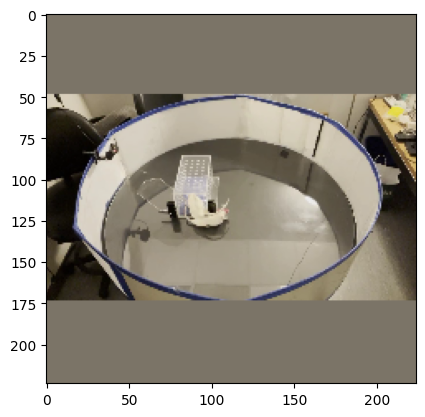

['interaction_with_partner&interaction_with_partner', 'interaction_with_partner&interaction_with_partner']
[0, 0]


In [1]:
import pickle
data_path='samples/sample_data.pkl'

# read data
with open(data_path, 'rb') as f:
    data=pickle.load(f)
# data[0][0].shape torch.Size([3, 16, 224, 224])
# show image data
import matplotlib.pyplot as plt
import torch
import numpy as np

# show image
def show_image(data):
    img=data.numpy()
    first_frame = img[:, 0, :, :]
    first_frame=np.transpose(first_frame, (1, 2, 0))
    first_frame=first_frame* np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    print(first_frame.max())
    print(first_frame.min())
    plt.imshow(first_frame)
    plt.show()

show_image(data[0][0])
print(data[1])
print(data[2])

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.distributed import DistributedSampler

class WeightedDistributedSampler(Sampler):
    def __init__(self, dataset, num_replicas, rank, weight_function, replacement=True):
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.weight_function = weight_function
        self.replacement = replacement

        # Create a DistributedSampler to handle indexing
        self.dist_sampler = DistributedSampler(
            self.dataset,
            num_replicas=self.num_replicas,
            rank=self.rank,
            shuffle=True,
            seed=42
        )
        self.indices = list(self.dist_sampler)  # Obtain indices for this process

        # Calculate weights only for the indices this sampler handles
        self.reduced_weights = self.weight_function(self.dataset, self.indices)

    def __iter__(self):
        # Weighted sampling from the reduced indices
        if self.replacement:
            return iter(torch.multinomial(torch.tensor(self.reduced_weights, dtype=torch.float), len(self.indices), replacement=True).tolist())
        else:
            # No replacement, shuffle to ensure random order
            sampled_indices = torch.multinomial(torch.tensor(self.reduced_weights, dtype=torch.float), len(self.indices), replacement=False)
            return iter([self.indices[i] for i in sampled_indices])

    def __len__(self):
        return len(self.indices)

# Example weight function that computes weights based on some property of the data
def compute_weights(dataset, indices):
    # For example, weights could be inversely proportional to the class frequency (assuming class labels are the second column)
    class_counts = {}
    for index in indices:
        label = dataset[index][1]
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    weights = [1.0 / class_counts.get(dataset[index][1], 1) for index in indices]
    return weights

# Example dataset setup
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.randn(100, 3)  # 100 samples, 3 features each
        self.labels = torch.randint(0, 5, (100,))  # Random integer labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = MyDataset()

# Use the custom sampler
sampler = WeightedDistributedSampler(dataset, num_replicas=4, rank=0, weight_function=compute_weights)
loader = DataLoader(dataset, batch_size=10, sampler=sampler)

for data in loader:
    print(data)


[tensor([[-0.1639, -1.5425, -3.0695],
        [ 0.7000,  0.8541,  0.7599],
        [ 1.3441, -0.0237,  1.1445],
        [ 0.7430,  0.6078,  0.2831],
        [-1.0962,  0.6532,  0.1058],
        [ 1.6799,  0.2420,  0.2213],
        [ 0.6286, -0.0251,  1.0599],
        [ 0.4240,  0.5797, -0.9058],
        [ 1.3441, -0.0237,  1.1445],
        [ 1.6735,  0.2521, -0.3379]]), tensor([2, 0, 0, 0, 4, 2, 1, 2, 0, 0])]
[tensor([[-0.6804, -0.1714, -0.1979],
        [-1.0962,  0.6532,  0.1058],
        [ 0.1303,  0.0711, -0.4397],
        [ 0.7000,  0.8541,  0.7599],
        [ 1.3441, -0.0237,  1.1445],
        [ 0.6286, -0.0251,  1.0599],
        [-0.9577,  0.0751, -0.4678],
        [-1.0962,  0.6532,  0.1058],
        [ 0.6286, -0.0251,  1.0599],
        [-2.3684, -0.4524, -0.1086]]), tensor([2, 4, 0, 0, 0, 1, 4, 4, 1, 3])]
[tensor([[ 0.1271, -0.4774,  0.3150],
        [ 1.0346, -1.3961, -0.4618],
        [ 0.6286, -0.0251,  1.0599],
        [ 0.1303,  0.0711, -0.4397],
        [ 0.4240,  0.5797

In [2]:
import torch
preds=torch.Tensor([[0.5,0,0.5],[1,0,0],[0,1,0]])
targets=torch.Tensor([[1,0,0],[0,1,0],[0,0.5,0.5]])
# preds_non_empty=(preds!=0)
# targets_non_empty=(targets!=0)
# # get indexes where both are non empty
# non_empty=preds_non_empty*targets_non_empty
# vals=torch.stack([preds[non_empty], targets[non_empty]]).min(dim=0).values
# count_correct = vals.sum()

count_correct=torch.sum(torch.min(preds, targets))
count_total = targets.sum()
count_correct

tensor(1.)

In [11]:

def multi_label_confusion_matrix(ground_truth_labels,pred_labels):
    """
    Calculate confusion matrix for multi-label classification.
    Args:
    - ground_truth_labels (torch.Tensor): ground truth binary labels. torch.tensor, [[0.5,0.5,0],[0,0,1],[0.5,0,0.5]], if 2 labels overlap, it is considered as 1.
    - pred_labels (torch.Tensor): predicted binary labels. same shape as ground_truth_labels.
    """
    
    # double ground truth labels and pred_labels, convert to int
    ground_truth_labels=ground_truth_labels*2
    ground_truth_labels=ground_truth_labels.int()
    pred_labels=pred_labels*2
    pred_labels=pred_labels.int()
    
    
    # emopty confusion matrix
    length=len(ground_truth_labels[0])
    confusion_matrix=torch.zeros((length,length))
    
    
    # calculate TPs
    # TPs=torch.sum(torch.min(ground_truth_labels, pred_labels),dim=0)
    
    # iterate over each label 
    for i in range(len(ground_truth_labels)):
        gt=ground_truth_labels[i]
        pred=pred_labels[i]

        # calculate TP
        tp=torch.min(gt,pred)
        # for each TP, increment the corresponding cell in the confusion matrix
        for j in range(length):
            if tp[j]==1:
                confusion_matrix[j,j]+=1
        
        # calculate FN
        gt=gt-tp
        pred=pred-tp
        # get non zero indexes
        gt_indexes=torch.nonzero(gt)
        pred_indexes=torch.nonzero(pred)
        # add to confusion matrix
        while torch.sum(gt)!=0:
            confusion_matrix[gt_indexes[0],pred_indexes[0]]+=1
            gt[gt_indexes[0]]-=1
            pred[pred_indexes[0]]-=1
            gt_indexes=torch.nonzero(gt)
            pred_indexes=torch.nonzero(pred)
        
    return confusion_matrix
    
   
ground_truth_labels=torch.Tensor([[0.5,0.5,0],[0,0,1],[0.5,0,0.5]])
pred_labels=torch.Tensor([[1,0,0],[0,1,0],[0,0.5,0.5]])
multi_label_confusion_matrix(ground_truth_labels,pred_labels)

tensor([[1., 1., 0.],
        [1., 0., 0.],
        [0., 2., 1.]])

torch.Size([3, 224, 224])
torch.Size([3, 256, 349])
tensor(0.9329, dtype=torch.float64)
tensor(2.7418e-09, dtype=torch.float64)


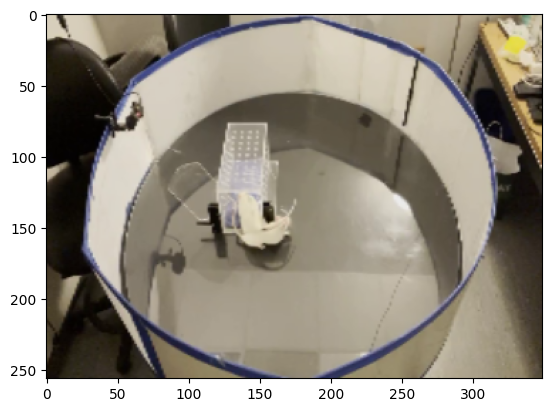

torch.Size([3, 224, 224])


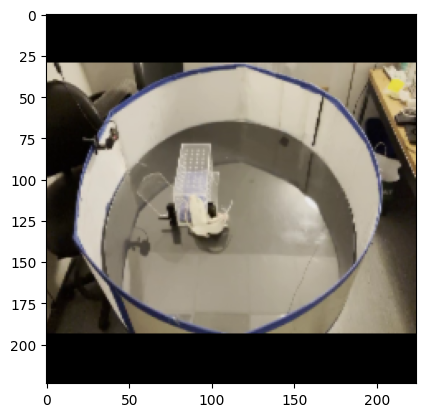

['interaction_with_partner&interaction_with_partner', 'interaction_with_partner&interaction_with_partner']
[0, 0]


In [22]:
import pickle
data_path='samples/sample_data.pkl'

# read data
with open(data_path, 'rb') as f:
    data=pickle.load(f)
# data[0][0].shape torch.Size([3, 16, 224, 224])
# show image data
import matplotlib.pyplot as plt
import torch
import numpy as np



from torchvision import transforms
    
    
def resize_pad(frame):
    """
    resize a frame's longer side to 224, pad the shorter side to 224
    """

    # get shape
    c, h, w = frame.shape

    # get longer side
    longer_side = max(h, w)

    # calculate ratio
    ratio = 224 / longer_side

    # resize with transform
    resize_transform = transforms.Resize((int(h * ratio), int(w * ratio)))
    frame = resize_transform(frame)

    # get new shape
    c, h, w = frame.shape

    # calculate padding needed to reach 224 for both dimensions
    pad_height = (224 - h) if h < 224 else 0
    pad_width = (224 - w) if w < 224 else 0

    # calculate padding for each side to center the image
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # apply padding
    padding_transform = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')
    frame = padding_transform(frame)

    return frame
 
def show_image(data):
    img=data.numpy()
    first_frame = img[:, 0, :, :]
    # resize to 256,349
    # convert to tensor
    first_frame=torch.tensor(first_frame)
    print(first_frame.shape)
    first_frame=transforms.Resize((256,349))(first_frame)
    print(first_frame.shape)
    
    first_frame=np.transpose(first_frame, (1, 2, 0))
    first_frame=first_frame* np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    print(first_frame.max())
    print(first_frame.min())
    plt.imshow(first_frame)
    plt.show()
    
    # transpose
    first_frame=np.transpose(first_frame, (2, 0, 1))
    frame=resize_pad(first_frame)
    print(frame.shape)
    
    frame=np.transpose(frame, (1, 2, 0))
    plt.imshow(frame)
    plt.show()
    
    
    


show_image(data[0][0])
print(data[1])
print(data[2])

In [4]:
# load data from ./outputs/***.pt

import os
import torch

path='./outputs/20240501-212658.pt'
# load data
data=torch.load(path)
for r in data:
    print(r)

tensor([0.2612, 0.1163, 0.3486, 0.1015, 0.0673, 0.0756, 0.0295],
       device='cuda:2', dtype=torch.float16)
tensor([0.1279, 0.1809, 0.2842, 0.1761, 0.0279, 0.1107, 0.0921],
       device='cuda:2', dtype=torch.float16)
tensor([0.1229, 0.1631, 0.3936, 0.1273, 0.0431, 0.1260, 0.0240],
       device='cuda:2', dtype=torch.float16)
tensor([0.1339, 0.0901, 0.4133, 0.0981, 0.0393, 0.1311, 0.0941],
       device='cuda:2', dtype=torch.float16)
tensor([0.1493, 0.2527, 0.2527, 0.1055, 0.0391, 0.1414, 0.0594],
       device='cuda:2', dtype=torch.float16)
tensor([0.1995, 0.1277, 0.3826, 0.0906, 0.0614, 0.0850, 0.0532],
       device='cuda:2', dtype=torch.float16)
tensor([0.3777, 0.1830, 0.2313, 0.0531, 0.0218, 0.1024, 0.0307],
       device='cuda:2', dtype=torch.float16)
tensor([0.1025, 0.1201, 0.3823, 0.1616, 0.0281, 0.1365, 0.0688],
       device='cuda:2', dtype=torch.float16)
tensor([0.0856, 0.0570, 0.6777, 0.0202, 0.0649, 0.0318, 0.0625],
       device='cuda:2', dtype=torch.float16)
tensor([0.